In this file I identify the best performing architecture for the 208Pb/207Pb model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
import shap
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
with open('../../Data/WOD_Pb_dataset-cleanedSOPbconc.csv', mode='r', newline='') as csvfile:
    WOD_pb_dataset = pd.read_csv(csvfile)
WOD_pb_dataset

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,...,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,...,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
1,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,...,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
2,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,...,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
3,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,...,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
4,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,...,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,...,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
9941,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,...,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
9942,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,...,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
9943,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,...,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


In [3]:
WOD_pb_dataset.isnull().sum()

Cruise                             0
WOD_depth                          0
WOD_latitude [degrees_north]       0
WOD_longitude [degrees_east]       0
Pb_CONC [pmol/kg]                 25
Pb_206_207                      7931
Pb_208_207                      7935
Ocean_basin                        0
Salinity                           0
Temperature                        0
Silicate                           0
Nitrate                            0
Phosphate                          0
Oxygen                             0
AOU                                0
MLD                                0
Sigma                              0
Chlorophyll-a                      0
Black Carbon AOD                   0
Dust AOD                           0
Bottom_distance                    0
dtype: int64

### Analyse and clean dataset for 208Pb/207Pb model

#### Drop rows with no 208Pb/207Pb data

In [4]:
pb_87_dataset = WOD_pb_dataset.dropna(subset = ['Pb_208_207'])
len(pb_87_dataset)

2010

##### Make copy of dataset for reference

In [5]:
pb_87_dataset_ref = pb_87_dataset.copy()
pb_87_dataset_ref

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,...,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,...,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
1,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,...,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
2,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,...,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
3,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,...,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
4,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,...,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,GP06-Chen2023,50,29.5,130.5,40.939276,1.1637,2.4471,Pacific,34.616,23.532,...,0.441,0.112,211.635,1.959,62.998,23.805,0.298270,0.011949,0.018216,3017.0
9938,GP06-Chen2023,800,29.5,130.5,26.550527,1.1655,2.4513,Pacific,34.323,4.794,...,35.664,2.547,79.362,233.159,62.998,30.883,0.298270,0.011949,0.018216,2267.0
9939,GP06-Chen2023,100,29.5,130.5,42.403400,1.1651,2.4470,Pacific,34.722,21.571,...,1.308,0.182,205.250,15.336,62.998,24.644,0.298270,0.011949,0.018216,2967.0
9940,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,...,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0


##### Analyse geographic sample distribution

In [6]:
pb_87_dataset['Ocean_basin'].value_counts()

Ocean_basin
Atlantic    789
Pacific     757
Arctic      228
Indian      170
Southern     66
Name: count, dtype: int64

In [7]:
pb_87_dataset.drop(['Ocean_basin'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### Plot sample distribution

facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".


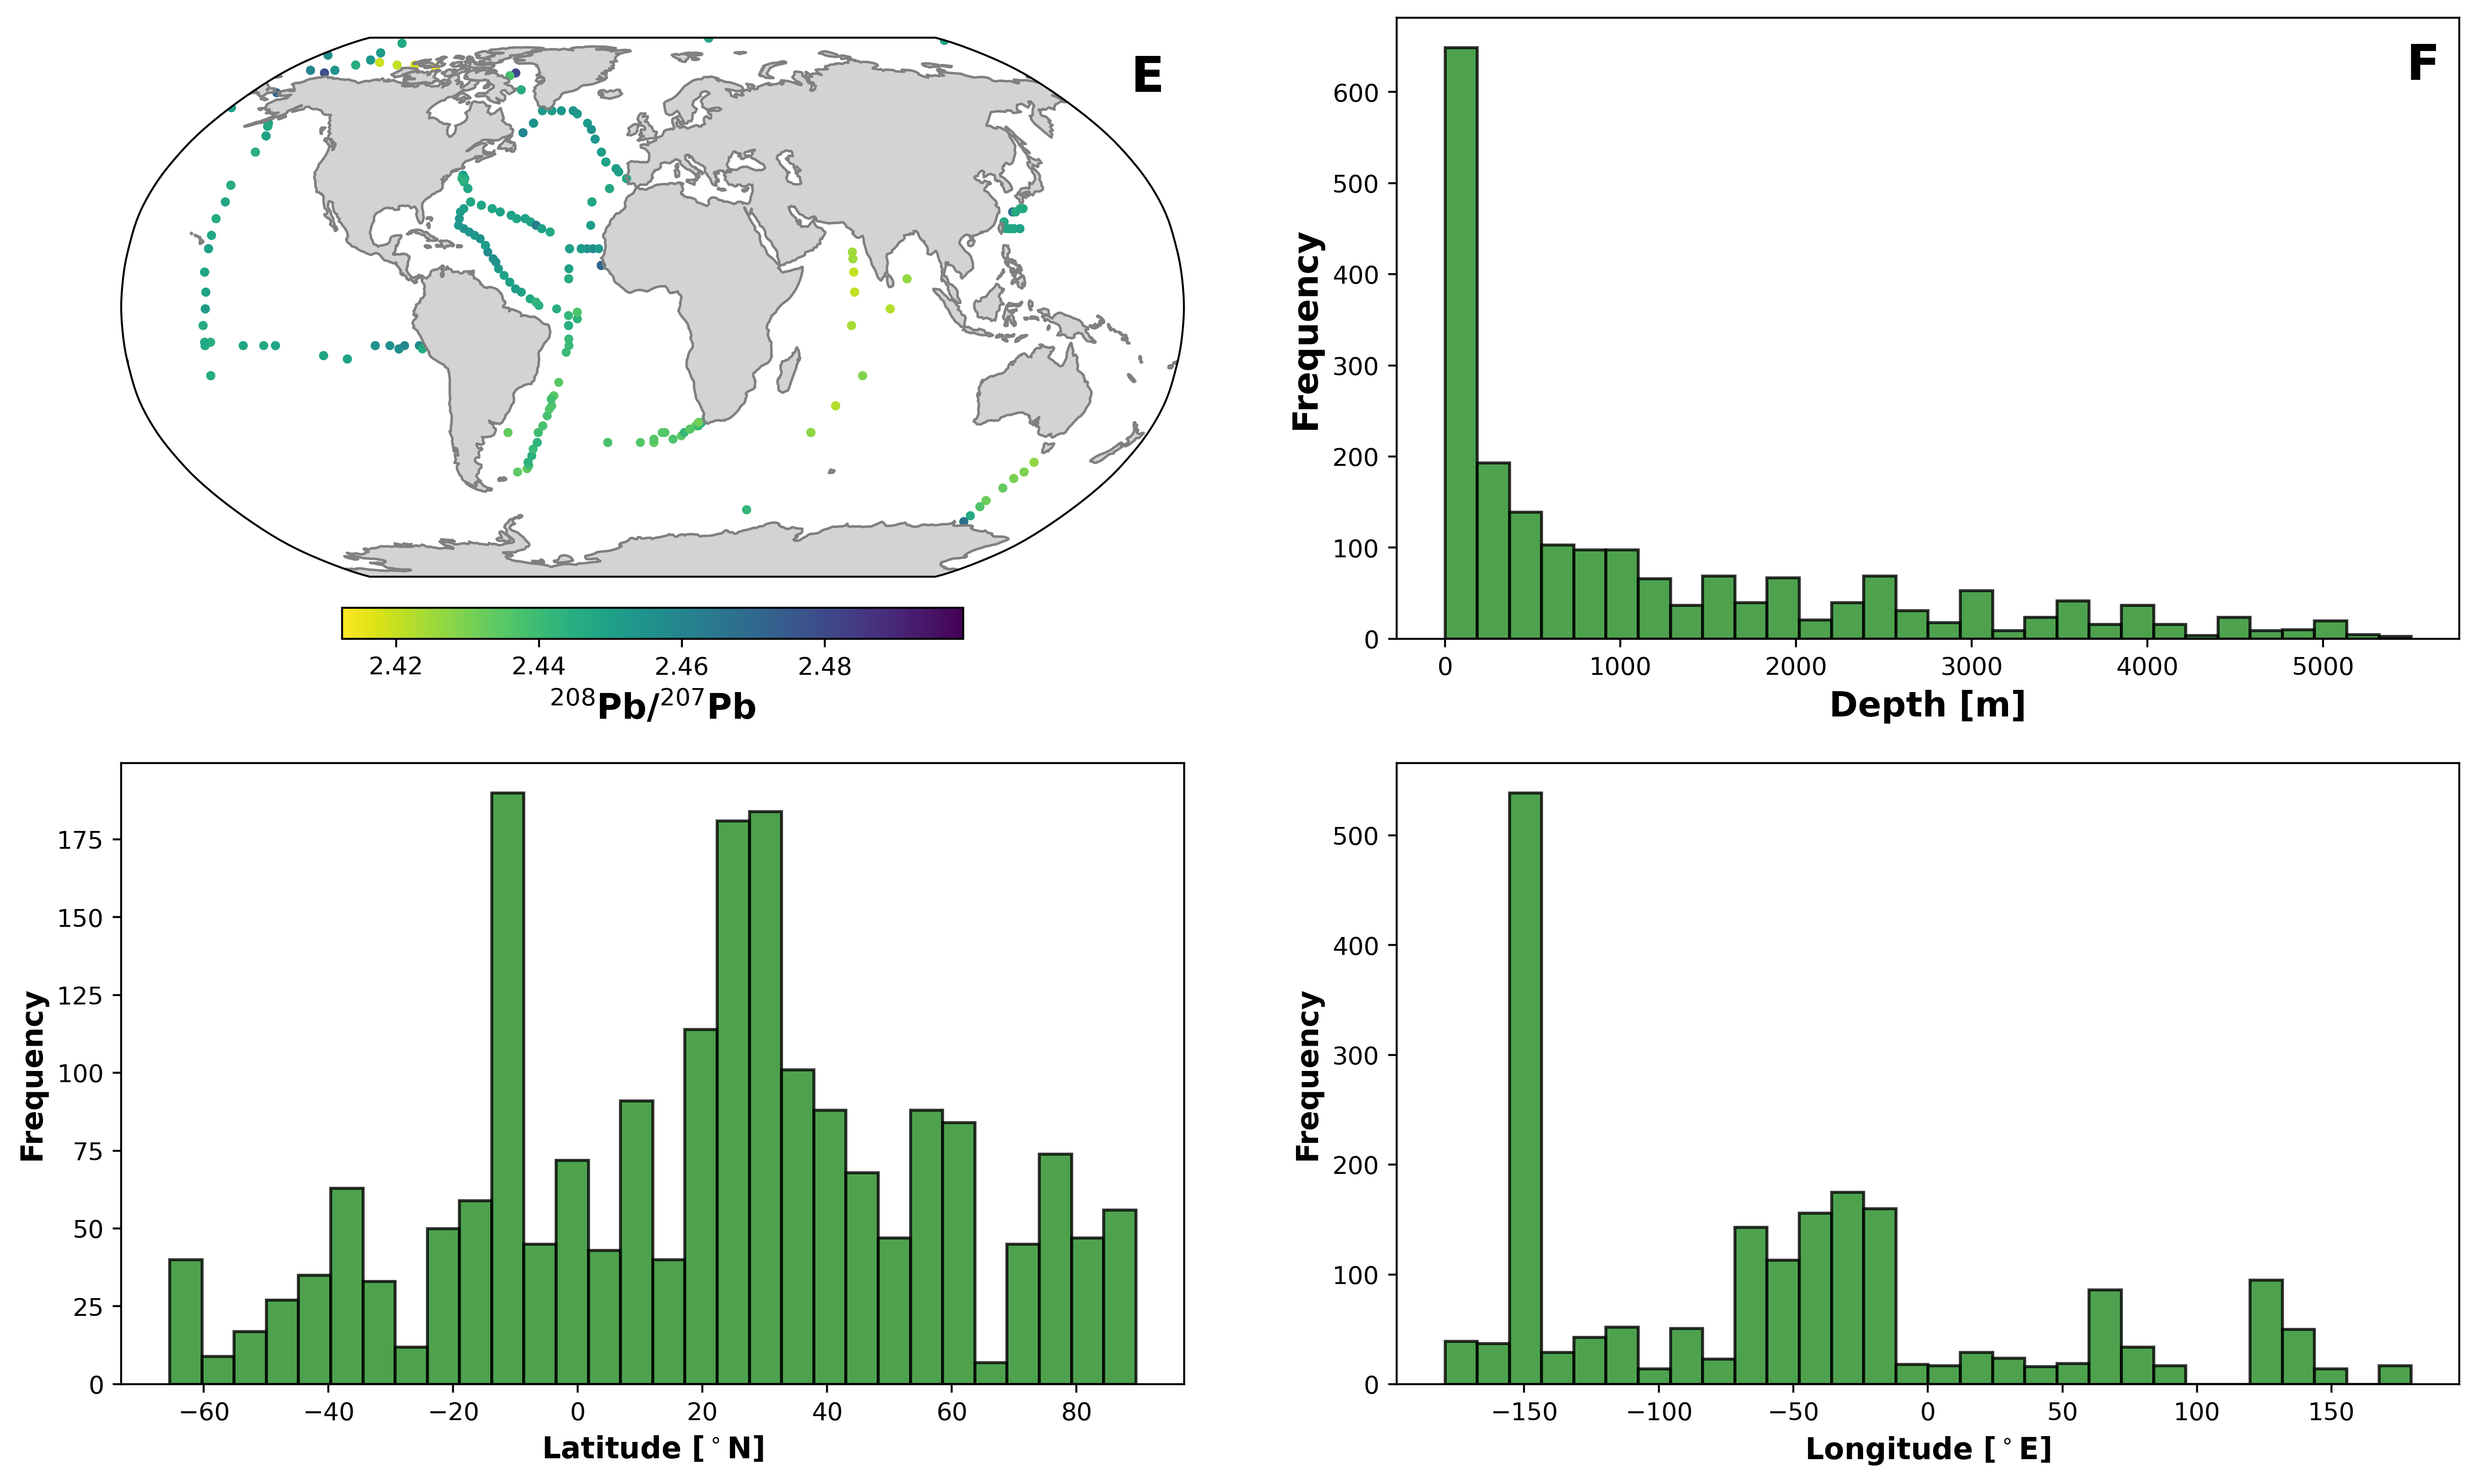

In [8]:
fig = plt.figure(figsize=(17,10), dpi = 400)

ax1 = fig.add_subplot(221, projection=ccrs.Robinson())
cs = ax1.scatter(pb_87_dataset[pb_87_dataset['WOD_depth'] < 100]['WOD_longitude [degrees_east]'], pb_87_dataset[pb_87_dataset['WOD_depth'] < 100]['WOD_latitude [degrees_north]'], c = pb_87_dataset[pb_87_dataset['WOD_depth'] < 100]['Pb_208_207'], cmap = 'viridis_r', s = 7, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, color='lightgrey')
ax1.add_feature(cfeature.COASTLINE, color = 'grey')
ax1.set_global()
ax1.text(0.95, 0.90, 'E', fontweight='bold', fontsize = 20, transform=ax1.transAxes)
plt.colorbar(cs, orientation = 'horizontal', fraction = 0.05, pad = 0.05).set_label(label = '$^{208}$Pb/$^{207}$Pb', size = 14, weight = 'bold')
ax2 = plt.subplot(222)
ax2.hist(pb_87_dataset['WOD_depth'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha = 0.8, linewidth = 1.2);
ax2.set_xlabel('Depth [m]', fontsize = 14, fontweight = 'bold')
ax2.set_ylabel('Frequency', fontsize = 14, fontweight = 'bold')
ax2.text(0.95, 0.90, 'F', fontweight='bold', fontsize = 20, transform=ax2.transAxes)
ax3 = plt.subplot(223)
ax3.hist(pb_87_dataset['WOD_latitude [degrees_north]'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha = 0.8, linewidth = 1.2);
ax3.set_xlabel('Latitude [$^\circ$N]', fontsize = 12, fontweight = 'bold')
ax3.set_ylabel('Frequency', fontsize = 12, fontweight = 'bold')
ax4 = plt.subplot(224)
ax4.hist(pb_87_dataset['WOD_longitude [degrees_east]'], bins = 30, color = 'forestgreen', edgecolor = 'black', alpha = 0.8, linewidth = 1.2);
ax4.set_xlabel('Longitude [$^\circ$E]', fontsize = 12, fontweight = 'bold')
ax4.set_ylabel('Frequency', fontsize = 12, fontweight = 'bold')


plt.savefig('../../Figures/For_ms/Pb_87_observations.png', dpi = 400)

#plt.tight_layout

## Model 208Pb/207Pb

##### Split train and test datasets

In [9]:
idx_1 = pb_87_dataset[(pb_87_dataset['Cruise'] == 'GA02') & (pb_87_dataset['WOD_latitude [degrees_north]'] < 0) & (pb_87_dataset['WOD_latitude [degrees_north]'] > -27)].index

test_geo_NA = pb_87_dataset.loc[idx_1]
test_geo_NA

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
9677,GA02,10,-26.5,-34.5,22.99,1.169481,2.437354,36.456,23.559,1.176,0.541,0.080,215.410,-3.844,63.771,24.945,0.063003,0.005483,0.000796,4565.0
9678,GA02,50,-26.5,-34.5,20.32,1.165135,2.434799,36.476,22.367,1.257,0.581,0.114,221.272,-5.113,63.771,25.469,0.063003,0.005483,0.000796,4525.0
9679,GA02,200,-26.5,-34.5,20.02,1.158544,2.430720,35.748,16.792,2.156,3.338,0.360,213.550,21.617,63.771,27.048,0.063003,0.005483,0.000796,4375.0
9680,GA02,500,-26.5,-34.5,17.58,1.155935,2.429565,34.882,10.605,6.895,17.116,1.110,206.901,66.096,63.771,29.042,0.063003,0.005483,0.000796,4075.0
9681,GA02,750,-26.5,-34.5,15.25,1.156255,2.428719,34.376,5.720,18.357,28.177,1.887,210.849,90.635,63.771,30.584,0.063003,0.005483,0.000796,3825.0
9682,GA02,1000,-26.5,-34.5,15.78,1.159101,2.432990,34.378,3.815,37.051,32.105,2.174,203.272,114.975,63.771,31.981,0.063003,0.005483,0.000796,3575.0
9683,GA02,1500,-26.5,-34.5,13.31,1.169352,2.443391,34.721,3.131,47.636,28.881,1.953,198.745,125.031,63.771,34.622,0.063003,0.005483,0.000796,3075.0
9684,GA02,2500,-26.5,-34.5,18.40,1.183084,2.454514,34.923,2.972,30.404,20.268,1.362,249.304,79.338,63.771,39.371,0.063003,0.005483,0.000796,2075.0
9685,GA02,3000,-26.5,-34.5,12.38,1.183619,2.454490,34.916,2.732,33.977,20.344,1.383,251.835,78.206,63.771,41.658,0.063003,0.005483,0.000796,1575.0
9686,GA02,3500,-26.5,-34.5,11.86,1.183184,2.455826,34.878,2.295,49.089,22.038,1.500,250.643,81.514,63.771,43.945,0.063003,0.005483,0.000796,1075.0


In [10]:
dataset = pb_87_dataset.drop(idx_1)
dataset

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
0,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,35.985,17.068,0.916,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
1,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,35.984,16.883,0.967,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
2,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,35.965,15.424,1.071,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
3,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,35.799,13.013,2.721,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
4,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,35.634,11.463,5.656,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,GP06-Chen2023,50,29.5,130.5,40.939276,1.1637,2.4471,34.616,23.532,3.787,0.441,0.112,211.635,1.959,62.998,23.805,0.298270,0.011949,0.018216,3017.0
9938,GP06-Chen2023,800,29.5,130.5,26.550527,1.1655,2.4513,34.323,4.794,88.319,35.664,2.547,79.362,233.159,62.998,30.883,0.298270,0.011949,0.018216,2267.0
9939,GP06-Chen2023,100,29.5,130.5,42.403400,1.1651,2.4470,34.722,21.571,4.656,1.308,0.182,205.250,15.336,62.998,24.644,0.298270,0.011949,0.018216,2967.0
9940,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,34.725,18.135,8.817,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0


In [11]:
y_test_geo_NA = test_geo_NA['Pb_208_207']
X_test_geo_NA = test_geo_NA.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [12]:
y = dataset['Pb_208_207']
X = dataset.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
#print((len(X_test) + len(X_test_geo_NA))/len(pb_87_dataset))


facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".


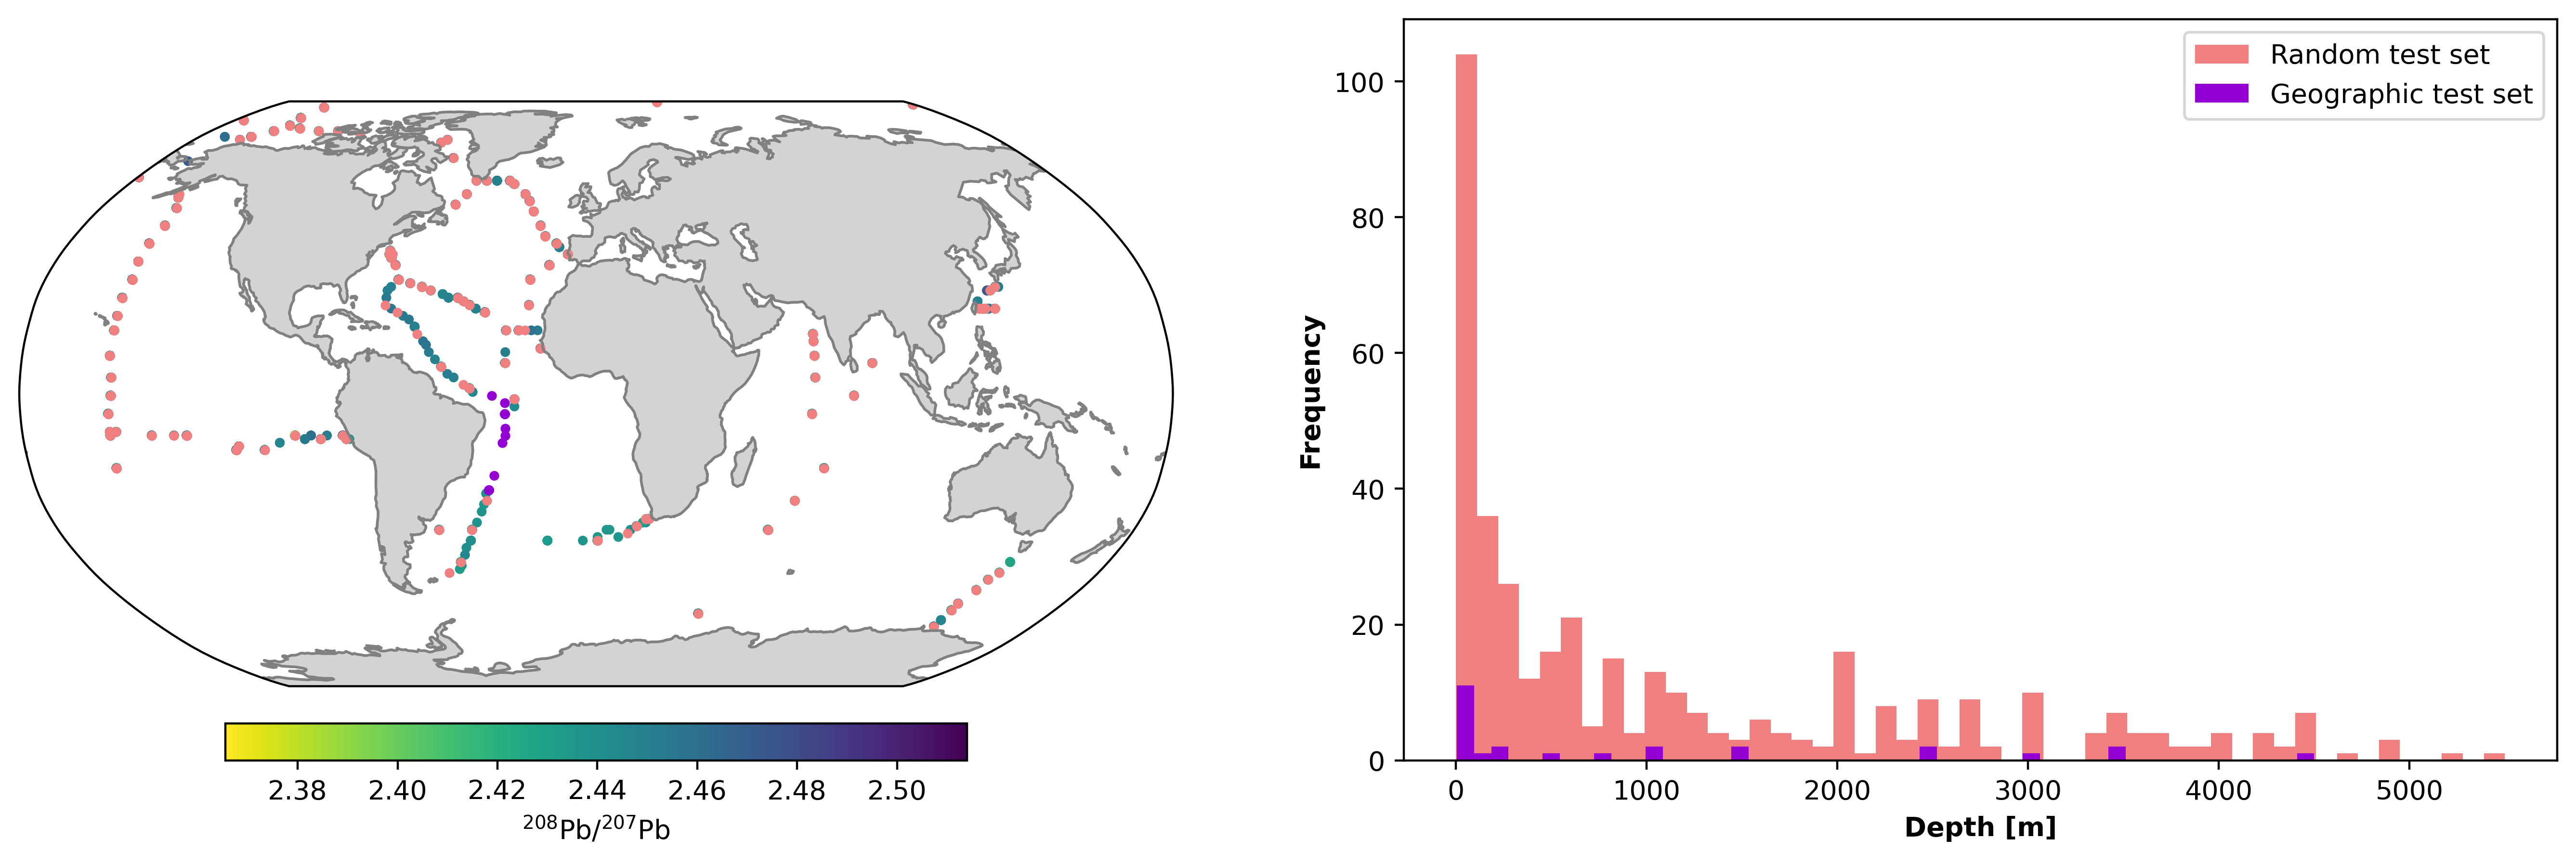

In [14]:
fig = plt.figure(figsize=(17,5), dpi = 400)

ax1 = fig.add_subplot(121, projection=ccrs.Robinson())
cs = ax1.scatter(X_train['WOD_longitude [degrees_east]'], X_train['WOD_latitude [degrees_north]'], c = y_train, cmap = ListedColormap(sns.color_palette('viridis_r', 256)), s = 7, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, color='lightgrey')
ax1.add_feature(cfeature.COASTLINE, color = 'grey')
ax1.set_global()
plt.colorbar(cs, orientation = 'horizontal', fraction = 0.05, pad = 0.05, label = '$^{208}$Pb/$^{207}$Pb')
ax1.scatter(X_test['WOD_longitude [degrees_east]'], X_test['WOD_latitude [degrees_north]'], c = 'lightcoral', s = 7, transform=ccrs.PlateCarree())
ax1.scatter(X_test_geo_NA['WOD_longitude [degrees_east]'], X_test_geo_NA['WOD_latitude [degrees_north]'], c = 'darkviolet', s = 7, transform=ccrs.PlateCarree())

ax2 = fig.add_subplot(122)
ax2.hist(X_test['WOD_depth'], bins = 50, color='lightcoral', label='Random test set')
ax2.hist(X_test_geo_NA['WOD_depth'], bins=50, color='darkviolet', label='Geographic test set')
ax2.legend()
ax2.set_xlabel('Depth [m]', fontweight = 'bold')
ax2.set_ylabel('Frequency', fontweight = 'bold')

plt.savefig('../../Figures/For_ms/87Pb_test_split.png', dpi = 400)

<Axes: >

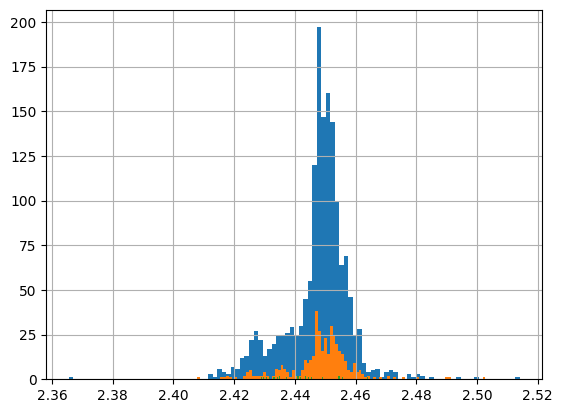

In [15]:
y_train.hist(bins=100)
y_test.hist(bins=100)
y_test_geo_NA.hist(bins=100)

#### Drop coordinates

In [16]:
for data in [X_train, X_test, X_test_geo_NA]:
    data.drop(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]'], axis=1, inplace=True)

#### EDA

In [17]:
num_cols = X_train.select_dtypes(include=np.number).columns

array([[<Axes: title={'center': 'WOD_depth'}>,
        <Axes: title={'center': 'Salinity'}>,
        <Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Silicate'}>],
       [<Axes: title={'center': 'Nitrate'}>,
        <Axes: title={'center': 'Phosphate'}>,
        <Axes: title={'center': 'Oxygen'}>,
        <Axes: title={'center': 'AOU'}>],
       [<Axes: title={'center': 'MLD'}>,
        <Axes: title={'center': 'Sigma'}>,
        <Axes: title={'center': 'Chlorophyll-a'}>,
        <Axes: title={'center': 'Black Carbon AOD'}>],
       [<Axes: title={'center': 'Dust AOD'}>,
        <Axes: title={'center': 'Bottom_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

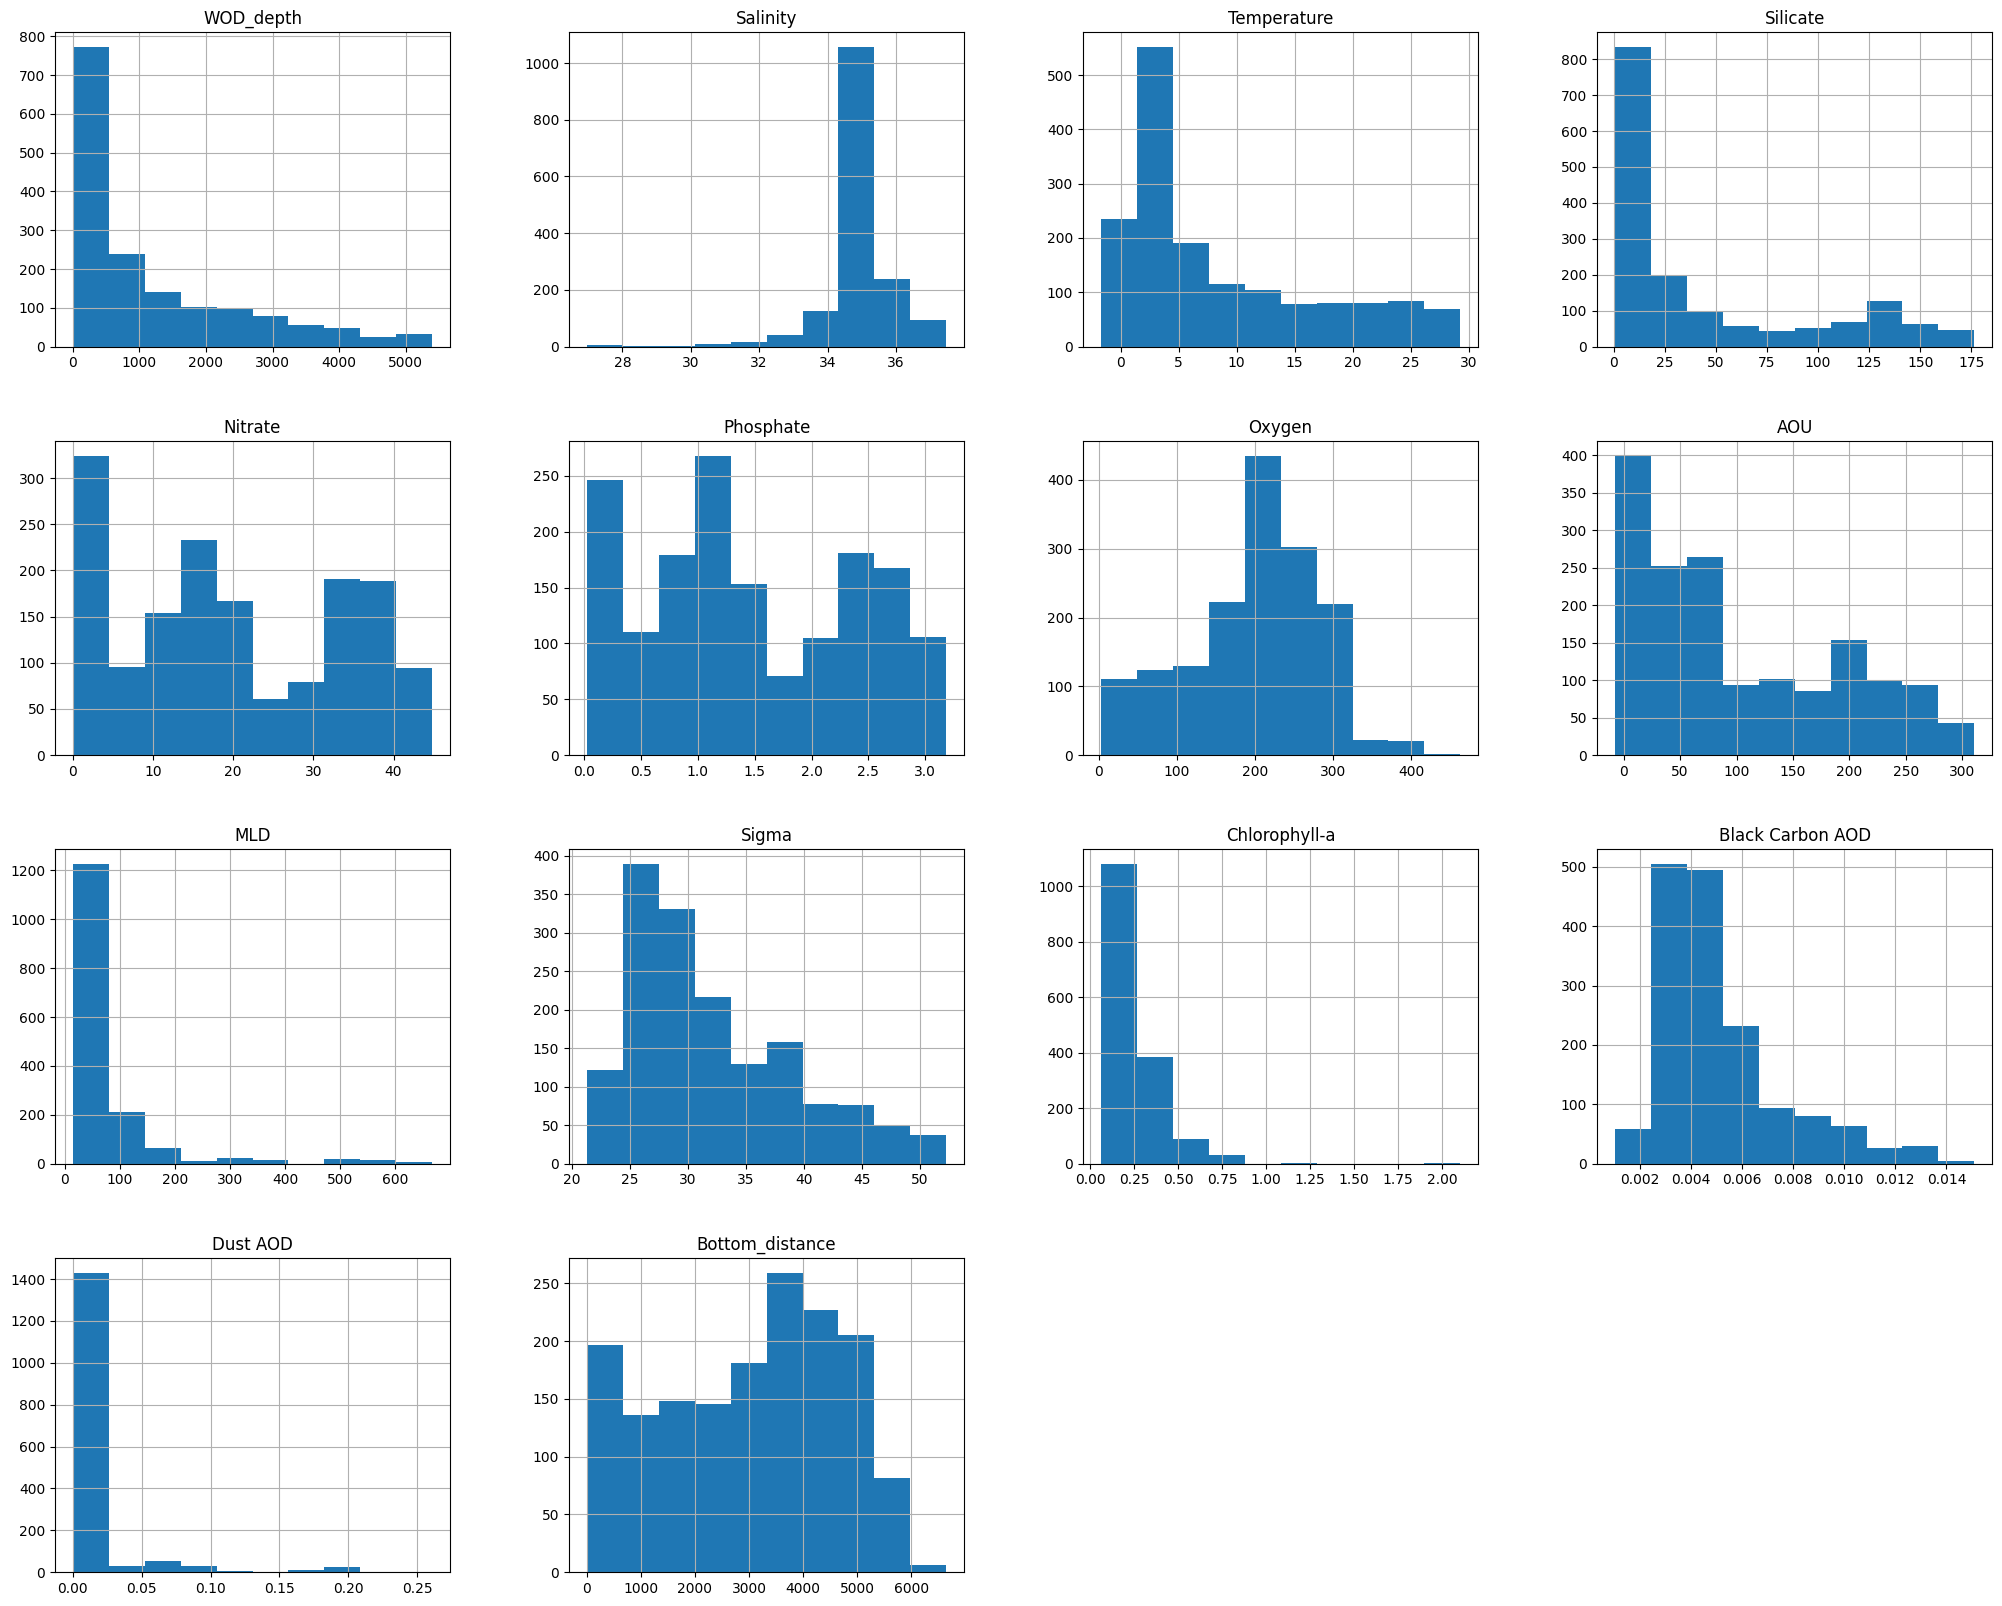

In [18]:
X_train[num_cols].hist(figsize=(25,20))

<Axes: >

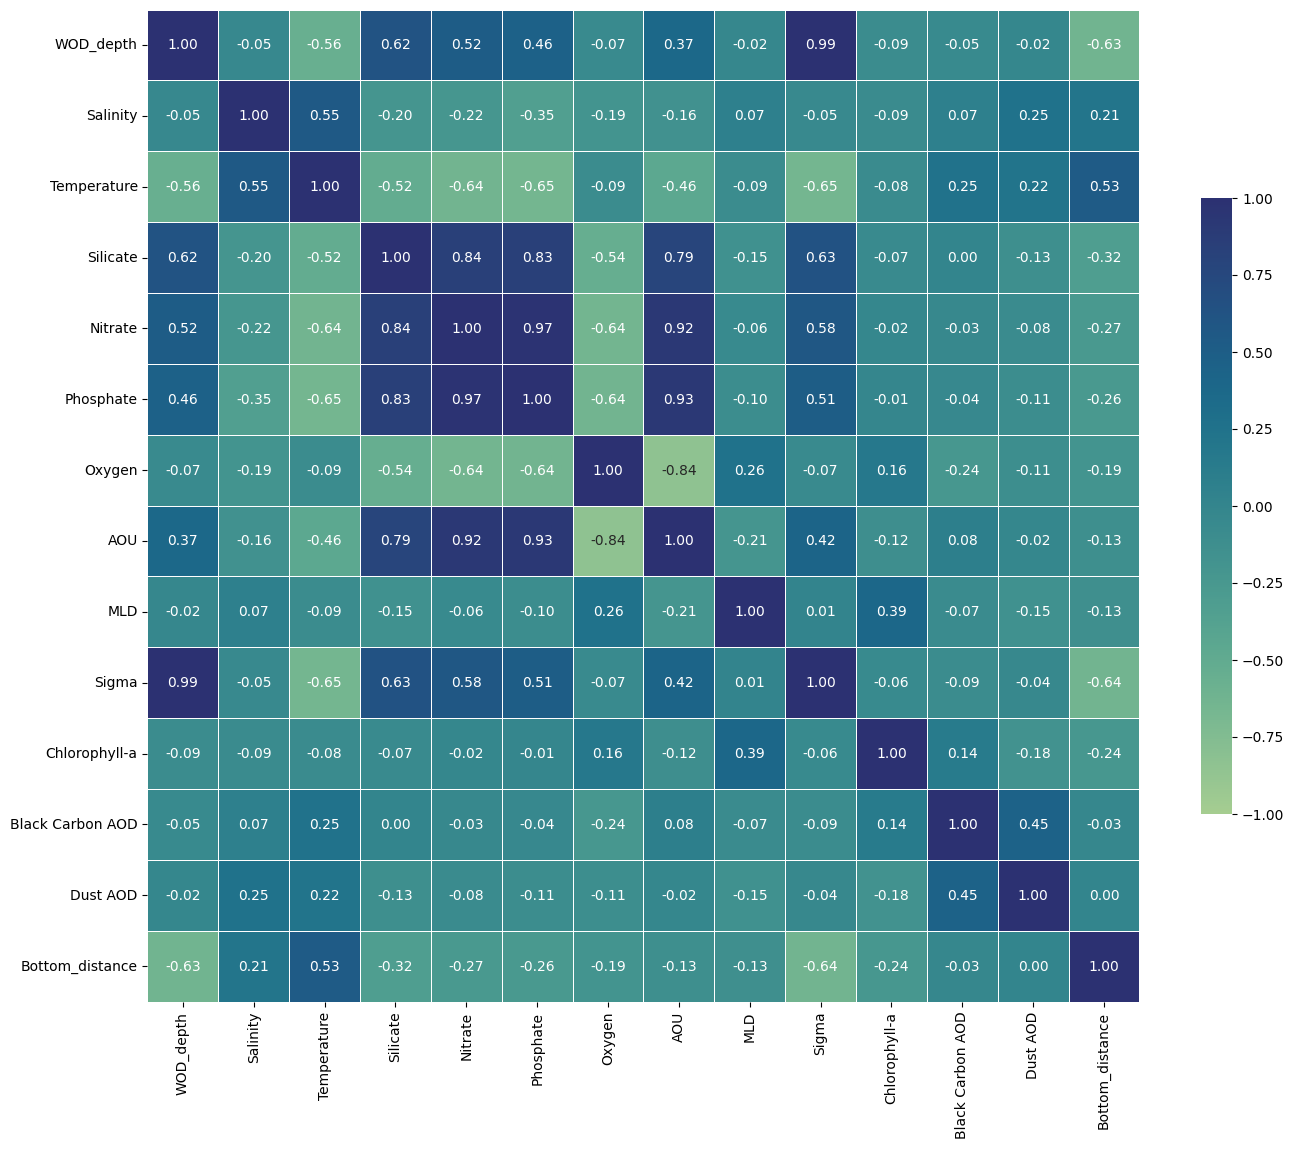

In [19]:
corr = X_train[num_cols].corr()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1, square=True, linewidths=.5, fmt='.2f', annot_kws={'size': 10}, cbar_kws={"shrink": .5})

## <strong style = "color:cyan"> Dummy model </strong>

In [20]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)

y_pred_dummy = dummy_reg.predict(X_test)


In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

print('RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_dummy))

RMSE: 0.010617680393777572 R2: -0.003315827039370056


Text(0.05, 0.83, 'n = 397')

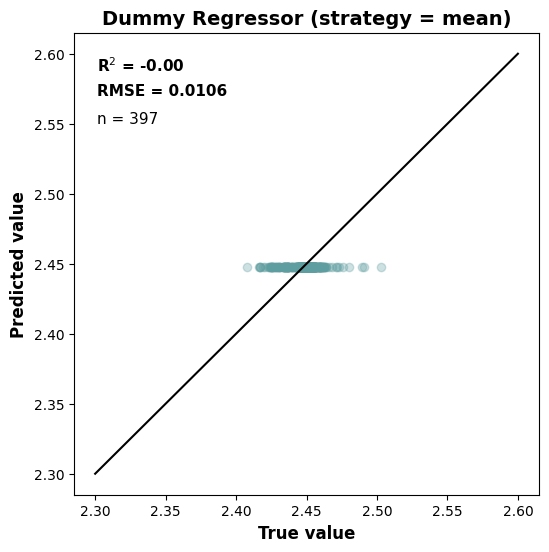

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_test, y_pred_dummy, c='cadetblue', alpha=0.3)
ax.plot(np.linspace(2.3, 2.6, 2), np.linspace(2.3, 2.6, 2), c='black')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('Dummy Regressor (strategy = mean)', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred_dummy):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.4f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

In [23]:
print('The average 208/207 value in our testing set is:', y_test.mean())

The average 208/207 value in our testing set is: 2.4481881048608947


## <strong style = "color:cyan"> Linear Regression </strong>

In [24]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

num_pipe = make_pipeline(MinMaxScaler())

num_cols = X_train.select_dtypes(include=np.number).columns
num_pipe.fit(X_train[num_cols])

X_train_scaled = pd.DataFrame(num_pipe.transform(X_train[num_cols]), columns=num_cols)
X_test_scaled = pd.DataFrame(num_pipe.transform(X_test[num_cols]), columns=num_cols)
X_test_geo_NA_scaled = pd.DataFrame(num_pipe.transform(X_test_geo_NA[num_cols]), columns=num_cols)

In [25]:
lin_reg = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print('RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_lin))

RMSE: 0.009727046473243064 R2: 0.15794521497914604


Text(0.05, 0.83, 'n = 397')

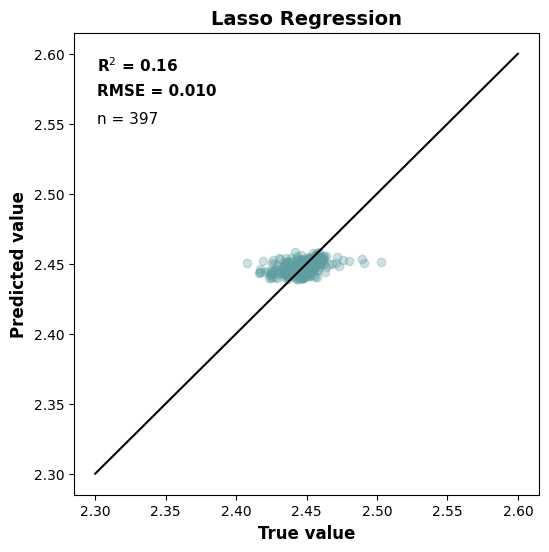

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_test, y_pred_lin, c='cadetblue', alpha=0.3)
ax.plot(np.linspace(2.3, 2.6, 2), np.linspace(2.3, 2.6, 2), c='black')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('Lasso Regression', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred_lin):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.3f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

## <strong style = "color:cyan"> Random Forest Regression </strong>

In [26]:
rf_r = RandomForestRegressor(random_state=42)
parameters = {'n_estimators': [400, 600, 800, 1000, 1200], 
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False],
              'max_features': [None, 'sqrt', 'log2']
              }

rf_grid = GridSearchCV(rf_r, 
                       parameters, 
                       cv=5,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1, 
                       verbose=1) 

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [400, 600, 800, 1000, 1200]},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
best_rf_model = rf_grid.best_estimator_
best_params = rf_grid.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


In [30]:
y_pred_rf = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
print('Random test set\n','RMSE:', rmse, 'R2:', r2_score(y_test, y_pred_rf), 'MAPE:', mape)

rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA)))
mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA))
print('Geographic test set\n', 'RMSE:', rmse_geo_NA, 'R2:', r2_score(y_test_geo_NA, best_rf_model.predict(X_test_geo_NA)), 'MAPE:', mape_geo_NA)

Random test set
 RMSE: 0.005651500325003798 R2: 0.7157464610976254 MAPE: 0.0013284435429229253
Geographic test set
 RMSE: 0.007527779690755383 R2: 0.3305066877694618 MAPE: 0.0024705680893146596


## <strong style = "color:cyan"> XGB Regression </strong>

In [33]:
xgb_r = XGBRegressor(seed = 42)
parameters = {'learning_rate': [0.01, 0.05, 0.1], #[0.01, 0.05, 0.1, 0.3]
              'n_estimators': [700, 800, 900, 1000, 1100], #[200, 400, 600, 800]
              'max_depth': [16, 18, 20, 22], #[6, 8, 10, 12]
              'colsample_bytree': [0.5, 0.7, 0.9, 1.0], #[0.5, 0.8, 0.9]
              'min_child_weight': [12, 14, 16, 18], #[3, 5, 7, 9]
              'reg_alpha': [0, 0.1, 1], #[0.1, 0.5, 1.0]
              'reg_lambda': [6, 8, 10, 12]} #[0.1, 0.5, 1.0]

xgb_grid = GridSearchCV(xgb_r,
                        parameters,
                        cv = 5,
                        scoring='neg_mean_squared_error',
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

df_results = pd.DataFrame(xgb_grid.cv_results_)
timestr = time.strftime("%Y%m%d-%H%M%S")
df_results.to_csv('Model_output/XGBoost-GridsearchCV_87pb_results_{0}.csv'.format(timestr), index=False)
df_results


Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.160228,0.154213,0.033746,0.002001,0.5,0.01,16,12,700,0,6,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.000025,-0.000046,-0.000040,-0.000032,-0.000051,-0.000039,0.000009,462
1,5.255995,0.484097,0.036416,0.005114,0.5,0.01,16,12,700,0,8,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.000026,-0.000045,-0.000040,-0.000032,-0.000051,-0.000039,0.000009,354
2,5.358276,0.578162,0.044446,0.007057,0.5,0.01,16,12,700,0,10,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.000026,-0.000045,-0.000040,-0.000031,-0.000051,-0.000039,0.000009,268
3,4.722222,0.493054,0.039266,0.005033,0.5,0.01,16,12,700,0,12,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.000026,-0.000045,-0.000040,-0.000031,-0.000051,-0.000039,0.000009,228
4,2.480657,0.129686,0.025767,0.003105,0.5,0.01,16,12,700,0.1,6,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",-0.000031,-0.000049,-0.000045,-0.000039,-0.000055,-0.000044,0.000008,6486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.568508,0.019390,0.006620,0.000434,1.0,0.1,22,18,1100,0.1,12,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-0.000031,-0.000048,-0.000044,-0.000038,-0.000055,-0.000043,0.000008,5449
11516,0.389642,0.024213,0.005574,0.000732,1.0,0.1,22,18,1100,1,6,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-0.000066,-0.000099,-0.000086,-0.000087,-0.000099,-0.000087,0.000012,7881
11517,0.382118,0.021160,0.005523,0.000504,1.0,0.1,22,18,1100,1,8,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-0.000067,-0.000099,-0.000086,-0.000087,-0.000099,-0.000088,0.000012,7981
11518,0.377541,0.013993,0.005304,0.000241,1.0,0.1,22,18,1100,1,10,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-0.000067,-0.000099,-0.000086,-0.000087,-0.000100,-0.000088,0.000012,8101


In [34]:
rmse_test = []
mape_test = []
rmse_test_geo_NA = []
mape_test_geo_NA = []

for i in range(0, len(df_results)):
    print(i)
    model = XGBRegressor(colsample_bytree=df_results['param_colsample_bytree'][i], 
                            learning_rate=df_results['param_learning_rate'][i], 
                            max_depth=df_results['param_max_depth'][i], 
                            min_child_weight=df_results['param_min_child_weight'][i], 
                            n_estimators=df_results['param_n_estimators'][i],
                            reg_alpha=df_results['param_reg_alpha'][i],
                            reg_lambda=df_results['param_reg_lambda'][i],
                            early_stopping_rounds=20,
                            seed=42)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test, iteration_range=(0, model.best_iteration + 1))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    rmse_test.append(rmse)
    mape_test.append(mape)

    y_pred_geo_NA = model.predict(X_test_geo_NA, iteration_range=(0, model.best_iteration + 1))
    rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, y_pred_geo_NA))
    mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, y_pred_geo_NA)

    rmse_test_geo_NA.append(rmse_geo_NA)
    mape_test_geo_NA.append(mape_geo_NA)

df_results['rmse_test'] = rmse_test
df_results['mape_test'] = mape_test
df_results['rmse_test_geo_NA'] = rmse_test_geo_NA
df_results['mape_test_geo_NA'] = mape_test_geo_NA

df_results.to_csv('Model_output/XGBoost-GridsearchCV_87pb_results_{0}_with-test-performance.csv'.format(timestr), index=False)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### <strong style = "color:cyan"> XGBoost - model analysis </strong>

In [27]:
model_grid = pd.read_csv('Model_output/XGBoost-GridsearchCV_87pb_results_20240923-170357_with-test-performance.csv')


In [28]:
model_grid.sort_values(by='rank_test_score', inplace=True)
model_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,...,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,rmse_test,mape_test,rmse_test_geo_NA,mape_test_geo_NA
626,4.774859,0.049889,0.038016,0.004607,0.5,0.01,20,16,900,0.0,...,-0.000041,-0.000030,-0.000052,-0.000038,0.000009,1,0.005727,0.001334,0.006432,0.002204
386,4.778028,0.213989,0.039192,0.002997,0.5,0.01,18,16,900,0.0,...,-0.000041,-0.000030,-0.000052,-0.000038,0.000009,2,0.005709,0.001331,0.006446,0.002213
819,5.438219,0.290906,0.043604,0.000759,0.5,0.01,22,14,1000,0.0,...,-0.000041,-0.000030,-0.000051,-0.000038,0.000009,3,0.005740,0.001336,0.006501,0.002223
279,5.683237,0.371366,0.045415,0.004968,0.5,0.01,18,12,1000,0.0,...,-0.000040,-0.000031,-0.000050,-0.000038,0.000009,4,0.005755,0.001330,0.006543,0.002244
267,5.674674,0.341297,0.040098,0.000940,0.5,0.01,18,12,900,0.0,...,-0.000040,-0.000031,-0.000050,-0.000038,0.000009,5,0.005755,0.001330,0.006543,0.002244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.500092,0.026824,0.010904,0.000867,0.5,0.01,16,18,1000,1.0,...,-0.000087,-0.000089,-0.000100,-0.000089,0.000012,11501,0.009129,0.002490,0.009625,0.003326
923,0.452289,0.028264,0.010101,0.001131,0.5,0.01,22,18,800,1.0,...,-0.000087,-0.000089,-0.000100,-0.000089,0.000012,11501,0.009129,0.002490,0.009625,0.003326
935,0.470680,0.016690,0.010182,0.001675,0.5,0.01,22,18,900,1.0,...,-0.000087,-0.000089,-0.000100,-0.000089,0.000012,11501,0.009129,0.002490,0.009625,0.003326
671,0.439521,0.028504,0.011096,0.002136,0.5,0.01,20,18,700,1.0,...,-0.000087,-0.000089,-0.000100,-0.000089,0.000012,11501,0.009129,0.002490,0.009625,0.003326


In [29]:
model_grid['rmse_val']=np.sqrt(-model_grid['mean_test_score'])

In [30]:
mean_rmse_cv = np.mean(model_grid['rmse_val'])
std2_rmse_cv = np.std(model_grid['rmse_val'])*2
mean_rmse_test = np.mean(model_grid['rmse_test'])
std2_rmse_test = np.std(model_grid['rmse_test'])*2
mean_rmse_test_geo_NA = np.mean(model_grid['rmse_test_geo_NA'])
std2_rmse_test_geo_NA = np.std(model_grid['rmse_test_geo_NA'])*2

print('Mean RMSE CV:', mean_rmse_cv, '+/-', std2_rmse_cv)
print('Mean RMSE test:', mean_rmse_test, '+/-', std2_rmse_test)
print('Mean RMSE test geo NA:', mean_rmse_test_geo_NA, '+/-', std2_rmse_test_geo_NA)

Mean RMSE CV: 0.007469913006961215 +/- 0.002732186874836526
Mean RMSE test: 0.00694638872382093 +/- 0.002984895843077297
Mean RMSE test geo NA: 0.008140069025585221 +/- 0.00252803527487352


In [31]:
model_grid.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,...,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,rmse_test,mape_test,rmse_test_geo_NA,mape_test_geo_NA,rmse_val
626,4.774859,0.049889,0.038016,0.004607,0.5,0.01,20,16,900,0.0,...,-0.000030,-0.000052,-0.000038,0.000009,1,0.005727,0.001334,0.006432,0.002204,0.006198
386,4.778028,0.213989,0.039192,0.002997,0.5,0.01,18,16,900,0.0,...,-0.000030,-0.000052,-0.000038,0.000009,2,0.005709,0.001331,0.006446,0.002213,0.006199
819,5.438219,0.290906,0.043604,0.000759,0.5,0.01,22,14,1000,0.0,...,-0.000030,-0.000051,-0.000038,0.000009,3,0.005740,0.001336,0.006501,0.002223,0.006200
279,5.683237,0.371366,0.045415,0.004968,0.5,0.01,18,12,1000,0.0,...,-0.000031,-0.000050,-0.000038,0.000009,4,0.005755,0.001330,0.006543,0.002244,0.006200
267,5.674674,0.341297,0.040098,0.000940,0.5,0.01,18,12,900,0.0,...,-0.000031,-0.000050,-0.000038,0.000009,5,0.005755,0.001330,0.006543,0.002244,0.006201
3254,4.310084,0.079751,0.034283,0.000893,0.7,0.01,18,16,800,0.0,...,-0.000031,-0.000051,-0.000038,0.000009,6,0.005687,0.001330,0.006730,0.002291,0.006201
3818,5.033011,0.062051,0.036590,0.002411,0.7,0.01,22,18,1000,0.0,...,-0.000031,-0.000052,-0.000038,0.000009,7,0.005715,0.001348,0.006943,0.002391,0.006201
747,5.608037,0.622292,0.038411,0.002416,0.5,0.01,22,12,900,0.0,...,-0.000031,-0.000050,-0.000038,0.000009,8,0.005767,0.001336,0.006468,0.002212,0.006201
3565,4.602469,0.289827,0.040732,0.003943,0.7,0.01,20,18,900,0.0,...,-0.000031,-0.000052,-0.000038,0.000009,9,0.005720,0.001331,0.006788,0.002338,0.006201
3255,4.021199,0.181526,0.032159,0.001008,0.7,0.01,18,16,800,0.0,...,-0.000030,-0.000052,-0.000038,0.000009,10,0.005694,0.001333,0.006746,0.002323,0.006201


In [32]:
best_xgb_model = XGBRegressor(colsample_bytree=model_grid['param_colsample_bytree'].to_numpy()[0], 
                              learning_rate=model_grid['param_learning_rate'].to_numpy()[0], 
                              max_depth=model_grid['param_max_depth'].to_numpy()[0], 
                              min_child_weight=model_grid['param_min_child_weight'].to_numpy()[0], 
                              n_estimators=model_grid['param_n_estimators'].to_numpy()[0],
                              reg_alpha=model_grid['param_reg_alpha'].to_numpy()[0],
                              reg_lambda=model_grid['param_reg_lambda'].to_numpy()[0], 
                              early_stopping_rounds=50,
                              eval_metric = 'rmse',
                              seed=42)

best_xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.01046	validation_1-rmse:0.01058
[1]	validation_0-rmse:0.01042	validation_1-rmse:0.01054
[2]	validation_0-rmse:0.01038	validation_1-rmse:0.01051
[3]	validation_0-rmse:0.01033	validation_1-rmse:0.01047
[4]	validation_0-rmse:0.01029	validation_1-rmse:0.01044
[5]	validation_0-rmse:0.01025	validation_1-rmse:0.01040
[6]	validation_0-rmse:0.01020	validation_1-rmse:0.01036
[7]	validation_0-rmse:0.01016	validation_1-rmse:0.01034
[8]	validation_0-rmse:0.01012	validation_1-rmse:0.01030
[9]	validation_0-rmse:0.01007	validation_1-rmse:0.01026
[10]	validation_0-rmse:0.01003	validation_1-rmse:0.01022
[11]	validation_0-rmse:0.00998	validation_1-rmse:0.01018
[12]	validation_0-rmse:0.00994	validation_1-rmse:0.01014
[13]	validation_0-rmse:0.00991	validation_1-rmse:0.01012
[14]	validation_0-rmse:0.00987	validation_1-rmse:0.01009
[15]	validation_0-rmse:0.00983	validation_1-rmse:0.01005
[16]	validation_0-rmse:0.00979	validation_1-rmse:0.01002
[17]	validation_0-rmse:0.00975	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=16, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
best_xgb_model.best_iteration

897

In [34]:
model_grid.rename(columns={'param_colsample_bytree': 'Columns Sampled by Tree', 'param_learning_rate': 'Learning Rate', 'param_max_depth': 'Maximum Depth', 'param_min_child_weight': 'Minimum Child Weight', 'param_n_estimators': 'Number of Trees', 'param_reg_alpha': 'L1 Regularization'}, inplace=True)

<Figure size 3000x3000 with 0 Axes>

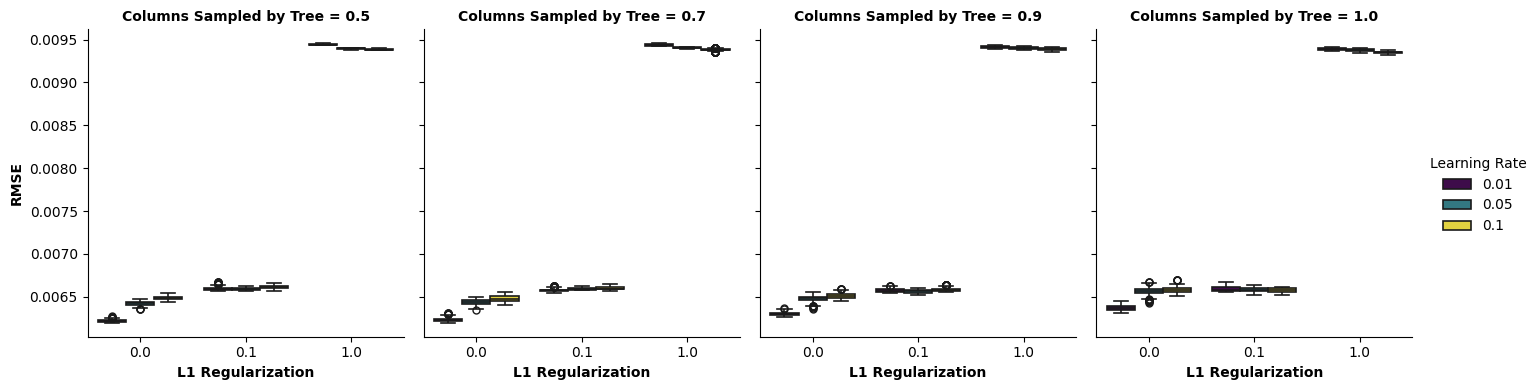

In [35]:
plt.figure(figsize=(10,10), dpi=300)
cat_plt = sns.catplot(x=model_grid['L1 Regularization'], y=model_grid['rmse_val'], hue=model_grid['Learning Rate'], col=model_grid['Columns Sampled by Tree'], kind="box", height=4, aspect=.9, linewidth=1.2, palette='viridis')
cat_plt.set_xlabels(fontweight='bold')
cat_plt.set_ylabels(label='RMSE', fontweight='bold')
cat_plt.set_titles(fontweight='bold')

plt.savefig('../../Figures/For_ms/XGBoost-GridsearchCV_87pb_results-catplot.png', dpi = 400)

In [36]:
y_pred = best_xgb_model.predict(X_test, iteration_range=(0, best_xgb_model.best_iteration + 1))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RMSE:', rmse, 'MAPE:', mape, 'R2:', r2_score(y_test, y_pred))

RMSE: 0.005709979757027959 MAPE: 0.0013299797674726443 R2: 0.7098333447571005


Text(0.05, 0.83, 'n = 397')

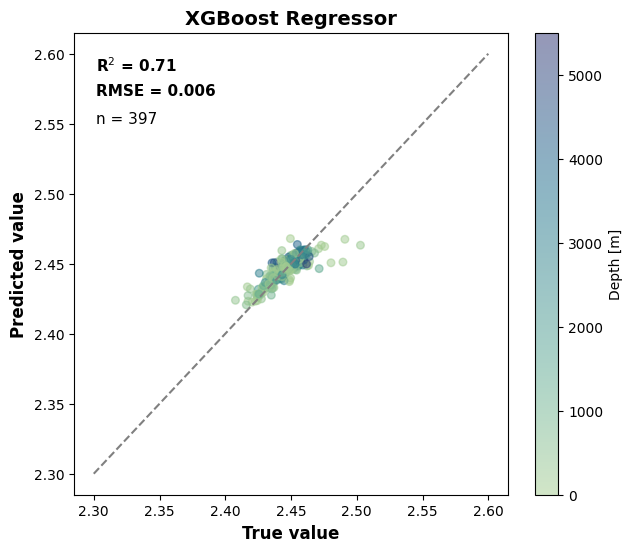

In [37]:
fig, ax = plt.subplots(1,1, figsize=(7,6))
c = ax.scatter(y_test, y_pred, c=X_test['WOD_depth'], cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=0.5, s=30)
fig.colorbar(c, label = 'Depth [m]')
ax.plot(np.linspace(2.3,2.6, 2), np.linspace(2.3, 2.6, 2), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.3f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_87pb_prediction-coldepth.png', dpi = 400)

In [38]:
y_pred_geo_NA = best_xgb_model.predict(X_test_geo_NA, iteration_range=(0, best_xgb_model.best_iteration + 1))
rmse_geo_NA = np.sqrt(mean_squared_error(y_test_geo_NA, y_pred_geo_NA))
mape_geo_NA = mean_absolute_percentage_error(y_test_geo_NA, y_pred_geo_NA)
print('RMSE:', rmse_geo_NA, 'MAPE:', mape_geo_NA, 'R2:', r2_score(y_test_geo_NA, y_pred_geo_NA))

RMSE: 0.006379545156703695 MAPE: 0.0021888429528649045 R2: 0.5191696484971668


Text(0.05, 0.83, 'n = 26')

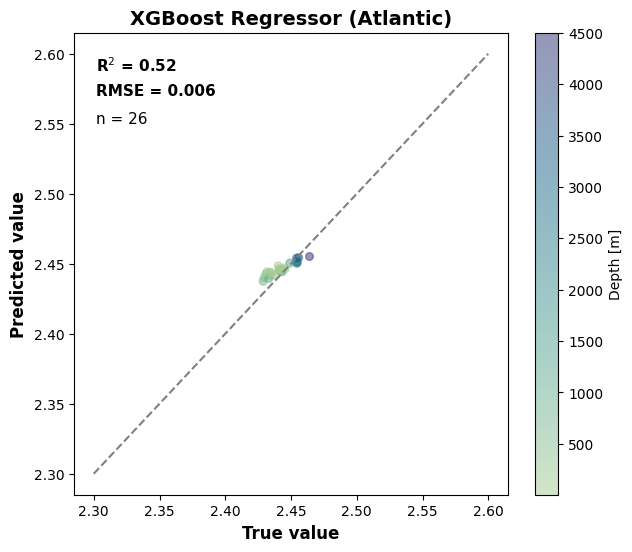

In [39]:
fig, ax = plt.subplots(1,1, figsize=(7,6))
c = ax.scatter(y_test_geo_NA, y_pred_geo_NA, c=X_test_geo_NA['WOD_depth'], cmap=ListedColormap(sns.color_palette('crest', 256)), alpha=0.5, s=30)
fig.colorbar(c, label = 'Depth [m]')
ax.plot(np.linspace(2.3,2.6, 2), np.linspace(2.3, 2.6, 2), c='grey', linestyle='--')
ax.set_xlabel('True value', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted value', fontweight='bold', fontsize=12)
ax.set_title('XGBoost Regressor (Atlantic)', fontweight='bold', fontsize=14)
ax.text(0.05, 0.95, f'R$^2$ = {r2_score(y_test_geo_NA, y_pred_geo_NA):.2f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.89, f'RMSE = {rmse:.3f}', transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax.text(0.05, 0.83, f'n = {len(y_test_geo_NA)}', transform=ax.transAxes, fontsize=11, va='top', ha='left')

#plt.savefig('../../Figures/XGBoost-bestmodel_67pb_Aprediction-coldepth.png', dpi = 400)

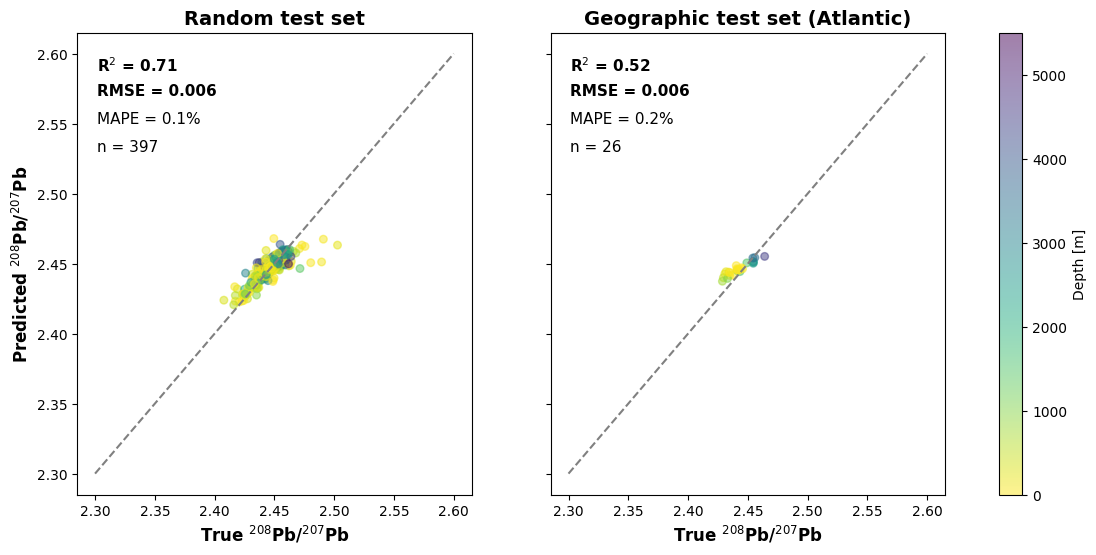

In [40]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,6))

ax[0].scatter(y_test, y_pred, c=X_test['WOD_depth'], cmap='viridis_r', vmin=0, vmax=5500, alpha=0.5, s=30)
ax[0].plot(np.linspace(2.3, 2.6, 2), np.linspace(2.3, 2.6, 2), c='grey', linestyle='--')
ax[0].set_xlabel('True $^{208}$Pb/$^{207}$Pb', fontweight='bold', fontsize=12)
ax[0].set_ylabel('Predicted $^{208}$Pb/$^{207}$Pb', fontweight='bold', fontsize=12)
ax[0].set_title('Random test set', fontweight='bold', fontsize=14)
ax[0].text(0.05, 0.95, f'R$^2$ = {r2_score(y_test, y_pred):.2f}', transform=ax[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[0].text(0.05, 0.89, f'RMSE = {rmse:.3f}', transform=ax[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[0].text(0.05, 0.83, f'MAPE = {mape*100:.1f}%', transform=ax[0].transAxes, fontsize=11, va='top', ha='left')
ax[0].text(0.05, 0.77, f'n = {len(y_test)}', transform=ax[0].transAxes, fontsize=11, va='top', ha='left')

c = ax[1].scatter(y_test_geo_NA, y_pred_geo_NA, c=X_test_geo_NA['WOD_depth'], cmap='viridis_r', vmin=0, vmax=5500, alpha=0.5, s=30)
ax[1].plot(np.linspace(2.3, 2.6, 2), np.linspace(2.3, 2.6, 2), c='grey', linestyle='--')
ax[1].set_xlabel('True $^{208}$Pb/$^{207}$Pb', fontweight='bold', fontsize=12)
ax[1].set_title('Geographic test set (Atlantic)', fontweight='bold', fontsize=14)
ax[1].text(0.05, 0.95, f'R$^2$ = {r2_score(y_test_geo_NA, y_pred_geo_NA):.2f}', transform=ax[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[1].text(0.05, 0.89, f'RMSE = {rmse_geo_NA:.3f}', transform=ax[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
ax[1].text(0.05, 0.83, f'MAPE = {mape_geo_NA*100:.1f}%', transform=ax[1].transAxes, fontsize=11, va='top', ha='left')
ax[1].text(0.05, 0.77, f'n = {len(y_test_geo_NA)}', transform=ax[1].transAxes, fontsize=11, va='top', ha='left')

fig.colorbar(c, label = 'Depth [m]', ax=ax.ravel().tolist())

plt.savefig('../../Figures/For_ms/XGBoost-bestmodel_87pb_2testsets-coldepth.png', dpi = 400)

### Regional results (random test set)

In [41]:
test_set_with_pred = X_test.copy()
test_set_with_pred['y_test'] = y_test
test_set_with_pred['y_pred'] = y_pred
#test_set_with_pred

In [42]:
merged_df = pd.merge(test_set_with_pred, pb_87_dataset_ref, left_index=True, right_index=True)
#merged_df

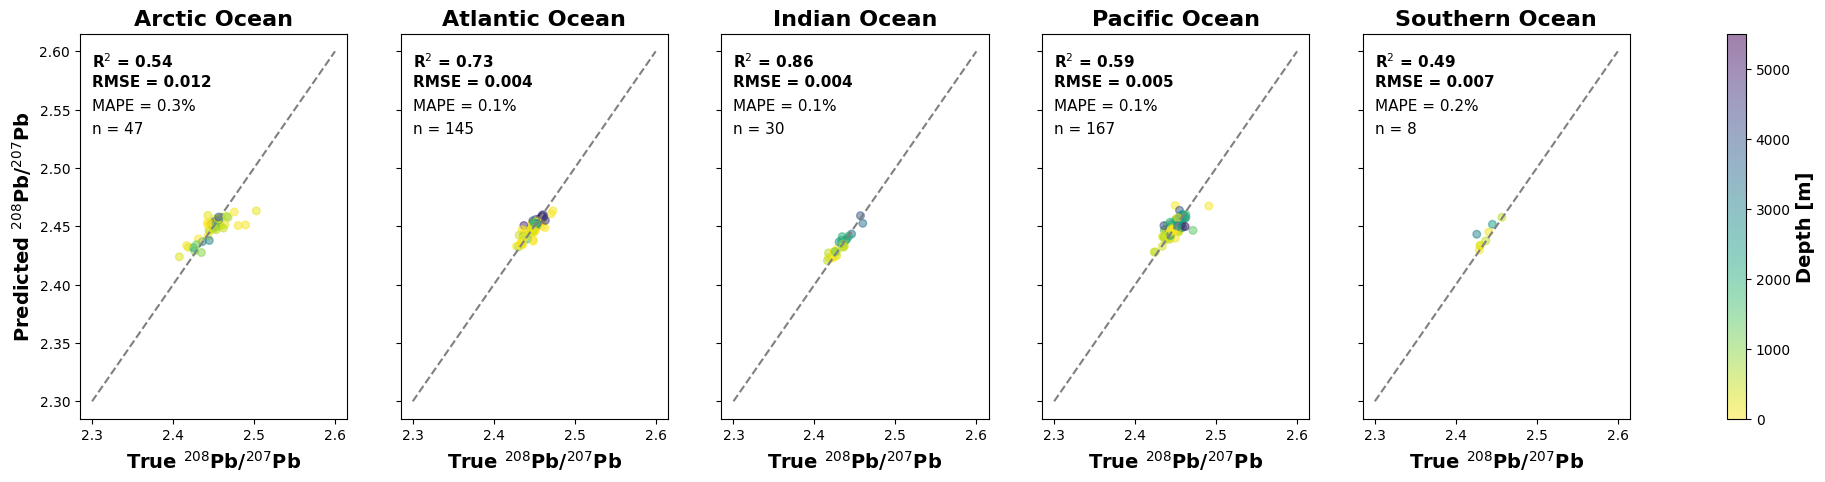

In [43]:
basins = sorted(merged_df['Ocean_basin'].unique())

fig, ax = plt.subplots(1,5, figsize=(25,5), sharey=True)

for i in range(0, len(basins)):
    c = ax[i].scatter(merged_df[merged_df['Ocean_basin'] == basins[i]]['y_test'], merged_df[merged_df['Ocean_basin'] == basins[i]]['y_pred'], c=merged_df[merged_df['Ocean_basin'] == basins[i]]['WOD_depth_x'], cmap='viridis_r', vmin = 0, vmax= 5500, alpha=0.5, s=30)
    ax[i].plot(np.linspace(2.3, 2.6, 2), np.linspace(2.3, 2.6, 2), c='grey', linestyle='--')
    ax[i].set_xlabel('True $^{208}$Pb/$^{207}$Pb', fontweight='bold', fontsize=14)
    if i == 0:
        ax[i].set_ylabel('Predicted $^{208}$Pb/$^{207}$Pb', fontweight='bold', fontsize=14)
    ax[i].set_title(f'{basins[i]} Ocean', fontweight='bold', fontsize=16)
    ax[i].text(2.3, 2.6, f'R$^2$ = {r2_score(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"]):.2f}', fontsize=11, fontweight='bold', va='top', ha='left')
    ax[i].text(2.3, 2.58, f'RMSE = {np.sqrt(mean_squared_error(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"])):.3f}', fontsize=11, fontweight='bold', va='top', ha='left')
    ax[i].text(2.3, 2.56, f'MAPE = {100*mean_absolute_percentage_error(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"], merged_df[merged_df["Ocean_basin"] == basins[i]]["y_pred"]):.1f}%', fontsize=11, va='top', ha='left')
    ax[i].text(2.3, 2.54, f'n = {len(merged_df[merged_df["Ocean_basin"] == basins[i]]["y_test"])}', fontsize=11, va='top', ha='left')

fig.colorbar(c, ax=ax.ravel().tolist()).set_label('Depth [m]', fontsize=14, fontweight='bold')
plt.savefig('../../Figures/For_ms/Pb_87_predictions_XGBoost_basin-performance.png', dpi =400)